### Notebook to investigate parenteral opioid dispensing trends
A notebook using [English Prescribing Data](https://www.nhsbsa.nhs.uk/prescription-data/prescribing-data/english-prescribing-data-epd) to investigate trends in parenteral opioid dispensing data.
- [Imports](#IMPORTS)
- [Standard functions](#FUNCTIONS)
- [OpenPrescribing data extract](#OPBNF)
- [Item plots](#CHARTS)

<a id='IMPORTS'></a>
### Imports
Import libraries required for analysis

In [1]:
#import libraries required for analysis
from ebmdatalab import bq
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

#set to display all rows in data
#pd.set_option('display.max_rows', None)

<a id='FUNCTIONS'></a>
### Standard functions
Setup standard functions

In [2]:
def plot(df, column_to_plot, chart_title, y_label, y_min='default', y_max='default', lockdownline=False):
    ax = df.groupby(["month"])[column_to_plot].sum().plot(kind='line', title=chart_title)
    plt.xticks(rotation=90);
    plt.ylabel(y_label);
    if (y_min!='default'):
        plt.ylim((y_min, y_max));
    else:
        y_max=df[column_to_plot].max() * 1.05
    if (lockdownline):
        plt.vlines(x=[pd.to_datetime("2020-03-23")], ymin=0, ymax=int(y_max), colors="red", ls="--", label="Start of restrictions");
    plt.grid();

<a id='OPBNF'></a>
### OpenPrescribing data extract
Get [English Prescribing Data](https://www.nhsbsa.nhs.uk/prescription-data/prescribing-data/english-prescribing-data-epd) from BigQuery for monthly items based on BNF codes in this [codelist](https://www.opencodelists.org/codelist/opensafely/opioid-containing-medicines-parenteral-excluding-drugs-for-substance-misuse-dmd/55a533f9/).

In [4]:
#OpenPrescribing BNF codes
sql = '''
SELECT
     CAST(month AS DATE) AS month,
     SUM (CASE WHEN bnf_code IN ("040702020AAAAAA", "040702020AAABAB", "040702020BBAAAA", "040702020BBABAB", "040702040AAABAB",
                                 "040702040BBABAB", "040702040BDAFAB", "040702050AAALAL", "040702050AAAMAM", "040702050AAANAN", 
                                 "040702050AAAPAP", "040702050BBAHAL", "040702050BBAIAM", "040702050BBAJAN", "040702050BBAKAP", 
                                 "0407020ABAAAAAA", "0407020ABAAABAB", "0407020ABAAAIAI", "0407020ABAAAKAK", "0407020ABAAAPAP", 
                                 "0407020ADAAALAL", "0407020ADAAAMAM", "0407020ADAAANAN", "0407020ADBBAFAL", "0407020ADBBAGAM", 
                                 "0407020ADBBAHAN", "0407020ADBJADAL", "0407020ADBJAEAM", "0407020ADBJAFAN", "0407020B0AAAAAA", 
                                 "0407020B0BBABAA", "0407020C0AAAAAA", "0407020C0AAAHAH", "0407020G0AAABAB", "0407020K0AAAAAA", 
                                 "0407020K0AAABAB", "0407020K0AAACAC", "0407020K0AAAEAE", "0407020K0AAAFAF", "0407020K0AAAGAG", 
                                 "0407020K0AAEFEF", "0407020K0AAEGEG", "0407020K0AAEHEH", "0407020K0AAEIEI", "0407020K0AAEMEM", 
                                 "0407020M0AAA3A3", "0407020M0AAA6A6", "0407020M0AAA8A8", "0407020M0AAACAC", "0407020M0AAANAN", 
                                 "0407020M0AAATAT", "0407020M0AAAVAV", "0407020M0AAAWAW", "0407020M0AABHBH", "0407020M0AABKBK", 
                                 "0407020M0BBABAV", "0407020M0BBACA3", "0407020M0BBADAT", "0407020M0BBAEAN", "0407020M0BBAHA6", 
                                 "0407020M0BBAIAC", "0407020M0BCAAAV", "0407020M0BCABAC", "0407020M0BCACA6", "0407020M0BCADAN", 
                                 "0407020P0AAAZAZ", "0407020P0AABABA", "0407020P0AABBBB", "0407020P0AABCBC", "0407020Q0AAA2A2", 
                                 "0407020Q0AAA3A3", "0407020Q0AAA4A4", "0407020Q0AAA5A5", "0407020Q0AAA8A8", "0407020Q0AAAAAA", 
                                 "0407020Q0AAABAB", "0407020Q0AAACAC", "0407020Q0AAADAD", "0407020Q0AAAEAE", "0407020Q0AAAFAF", 
                                 "0407020Q0AAAMAM", "0407020Q0AABCBC", "0407020Q0AADIDI", "0407020Q0AAELEL", "0407020Q0AAENEN", 
                                 "0407020Q0AAFCFC", "0407020Q0AAFJFJ", "0407020Q0AAFKFK", "0407020Q0AAFPFP", "0407020Q0AAFRFR", 
                                 "0407020Q0AAFTFT", "0407020Q0AAFVFV", "0407020Q0AAFWFW", "0407020Q0AAFZFZ", "0407020Q0AAGAGA", 
                                 "0407020Q0BEABFJ", "0407020U0AAAAAA", "0407020U0AAACAC", "0407020U0BBAAAA", "0407020U0BBABAC", 
                                 "0407020V0AAAAAA", "0407020V0AAAEAE", "0407020V0AAAIAI", "0407020V0AAALAL", "0407020V0AAAPAP", 
                                 "0407020V0AAAXAX", "0407020V0AAAZAZ", "0407020V0BCAAAI", "0407020Y0AAAAAA", "0407020Y0AAADAD", 
                                 "0407020Y0BBAAAA", "0407020Y0BBABAD", "1501043A0AAABAB", "1501043A0AAACAC", "1501043A0AAADAD", 
                                 "1501043A0AAAFAF", "1501043A0AAAHAH", "1501043A0BBAAAB", "1501043A0BBABAC", "1501043A0BBADAD"
                                 )  THEN items ELSE 0 END) as ParenteralOpioids,
 FROM hscic.normalised_prescribing
 WHERE month >= '2018-01-01'
 GROUP BY month
 ORDER BY month'''

OP_DF = bq.cached_read(sql, csv_path=os.path.join('../..','data','parenteralopioids.csv'))

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=jgSvqeRL3mrwehwjeq0zMZNL1qfSUS&prompt=consent&access_type=offline


Enter the authorization code:  4/1AfgeXvsBSKgBTSm8nQCBuS4P7tmeRtgrTZGITjt7emDbCHcNZ67ug_MB59E


Downloading: 100%|██████████| 57/57 [00:00<00:00, 262.22rows/s]


In [16]:
#OpenPrescribing BNF codes
sql = '''
SELECT
    CAST(month AS DATE) AS month,
SUM (CASE WHEN bnf_code = "040702020AAAAAA"  THEN items ELSE 0 END) as ID_040702020AAAAAA,
SUM (CASE WHEN bnf_code = "040702020AAABAB"  THEN items ELSE 0 END) as ID_040702020AAABAB,
SUM (CASE WHEN bnf_code = "040702020BBAAAA"  THEN items ELSE 0 END) as ID_040702020BBAAAA,
SUM (CASE WHEN bnf_code = "040702020BBABAB"  THEN items ELSE 0 END) as ID_040702020BBABAB,
SUM (CASE WHEN bnf_code = "040702040AAABAB"  THEN items ELSE 0 END) as ID_040702040AAABAB,
SUM (CASE WHEN bnf_code = "040702040BBABAB"  THEN items ELSE 0 END) as ID_040702040BBABAB,
SUM (CASE WHEN bnf_code = "040702040BDAFAB"  THEN items ELSE 0 END) as ID_040702040BDAFAB,
SUM (CASE WHEN bnf_code = "040702050AAALAL"  THEN items ELSE 0 END) as ID_040702050AAALAL,
SUM (CASE WHEN bnf_code = "040702050AAAMAM"  THEN items ELSE 0 END) as ID_040702050AAAMAM,
SUM (CASE WHEN bnf_code = "040702050AAANAN"  THEN items ELSE 0 END) as ID_040702050AAANAN,
SUM (CASE WHEN bnf_code = "040702050AAAPAP"  THEN items ELSE 0 END) as ID_040702050AAAPAP,
SUM (CASE WHEN bnf_code = "040702050BBAHAL"  THEN items ELSE 0 END) as ID_040702050BBAHAL,
SUM (CASE WHEN bnf_code = "040702050BBAIAM"  THEN items ELSE 0 END) as ID_040702050BBAIAM,
SUM (CASE WHEN bnf_code = "040702050BBAJAN"  THEN items ELSE 0 END) as ID_040702050BBAJAN,
SUM (CASE WHEN bnf_code = "040702050BBAKAP"  THEN items ELSE 0 END) as ID_040702050BBAKAP,
SUM (CASE WHEN bnf_code = "0407020ABAAAAAA"  THEN items ELSE 0 END) as ID_0407020ABAAAAAA,
SUM (CASE WHEN bnf_code = "0407020ABAAABAB"  THEN items ELSE 0 END) as ID_0407020ABAAABAB,
SUM (CASE WHEN bnf_code = "0407020ABAAAIAI"  THEN items ELSE 0 END) as ID_0407020ABAAAIAI,
SUM (CASE WHEN bnf_code = "0407020ABAAAKAK"  THEN items ELSE 0 END) as ID_0407020ABAAAKAK,
SUM (CASE WHEN bnf_code = "0407020ABAAAPAP"  THEN items ELSE 0 END) as ID_0407020ABAAAPAP,
SUM (CASE WHEN bnf_code = "0407020ADAAALAL"  THEN items ELSE 0 END) as ID_0407020ADAAALAL,
SUM (CASE WHEN bnf_code = "0407020ADAAAMAM"  THEN items ELSE 0 END) as ID_0407020ADAAAMAM,
SUM (CASE WHEN bnf_code = "0407020ADAAANAN"  THEN items ELSE 0 END) as ID_0407020ADAAANAN,
SUM (CASE WHEN bnf_code = "0407020ADBBAFAL"  THEN items ELSE 0 END) as ID_0407020ADBBAFAL,
SUM (CASE WHEN bnf_code = "0407020ADBBAGAM"  THEN items ELSE 0 END) as ID_0407020ADBBAGAM,
SUM (CASE WHEN bnf_code = "0407020ADBBAHAN"  THEN items ELSE 0 END) as ID_0407020ADBBAHAN,
SUM (CASE WHEN bnf_code = "0407020ADBJADAL"  THEN items ELSE 0 END) as ID_0407020ADBJADAL,
SUM (CASE WHEN bnf_code = "0407020ADBJAEAM"  THEN items ELSE 0 END) as ID_0407020ADBJAEAM,
SUM (CASE WHEN bnf_code = "0407020ADBJAFAN"  THEN items ELSE 0 END) as ID_0407020ADBJAFAN,
SUM (CASE WHEN bnf_code = "0407020B0AAAAAA"  THEN items ELSE 0 END) as ID_0407020B0AAAAAA,
SUM (CASE WHEN bnf_code = "0407020B0BBABAA"  THEN items ELSE 0 END) as ID_0407020B0BBABAA,
SUM (CASE WHEN bnf_code = "0407020C0AAAAAA"  THEN items ELSE 0 END) as ID_0407020C0AAAAAA,
SUM (CASE WHEN bnf_code = "0407020C0AAAHAH"  THEN items ELSE 0 END) as ID_0407020C0AAAHAH,
SUM (CASE WHEN bnf_code = "0407020G0AAABAB"  THEN items ELSE 0 END) as ID_0407020G0AAABAB,
SUM (CASE WHEN bnf_code = "0407020K0AAAAAA"  THEN items ELSE 0 END) as ID_0407020K0AAAAAA,
SUM (CASE WHEN bnf_code = "0407020K0AAABAB"  THEN items ELSE 0 END) as ID_0407020K0AAABAB,
SUM (CASE WHEN bnf_code = "0407020K0AAACAC"  THEN items ELSE 0 END) as ID_0407020K0AAACAC,
SUM (CASE WHEN bnf_code = "0407020K0AAAEAE"  THEN items ELSE 0 END) as ID_0407020K0AAAEAE,
SUM (CASE WHEN bnf_code = "0407020K0AAAFAF"  THEN items ELSE 0 END) as ID_0407020K0AAAFAF,
SUM (CASE WHEN bnf_code = "0407020K0AAAGAG"  THEN items ELSE 0 END) as ID_0407020K0AAAGAG,
SUM (CASE WHEN bnf_code = "0407020K0AAEFEF"  THEN items ELSE 0 END) as ID_0407020K0AAEFEF,
SUM (CASE WHEN bnf_code = "0407020K0AAEGEG"  THEN items ELSE 0 END) as ID_0407020K0AAEGEG,
SUM (CASE WHEN bnf_code = "0407020K0AAEHEH"  THEN items ELSE 0 END) as ID_0407020K0AAEHEH,
SUM (CASE WHEN bnf_code = "0407020K0AAEIEI"  THEN items ELSE 0 END) as ID_0407020K0AAEIEI,
SUM (CASE WHEN bnf_code = "0407020K0AAEMEM"  THEN items ELSE 0 END) as ID_0407020K0AAEMEM,
SUM (CASE WHEN bnf_code = "0407020M0AAA3A3"  THEN items ELSE 0 END) as ID_0407020M0AAA3A3,
SUM (CASE WHEN bnf_code = "0407020M0AAA6A6"  THEN items ELSE 0 END) as ID_0407020M0AAA6A6,
SUM (CASE WHEN bnf_code = "0407020M0AAA8A8"  THEN items ELSE 0 END) as ID_0407020M0AAA8A8,
SUM (CASE WHEN bnf_code = "0407020M0AAACAC"  THEN items ELSE 0 END) as ID_0407020M0AAACAC,
SUM (CASE WHEN bnf_code = "0407020M0AAANAN"  THEN items ELSE 0 END) as ID_0407020M0AAANAN,
SUM (CASE WHEN bnf_code = "0407020M0AAATAT"  THEN items ELSE 0 END) as ID_0407020M0AAATAT,
SUM (CASE WHEN bnf_code = "0407020M0AAAVAV"  THEN items ELSE 0 END) as ID_0407020M0AAAVAV,
SUM (CASE WHEN bnf_code = "0407020M0AAAWAW"  THEN items ELSE 0 END) as ID_0407020M0AAAWAW,
SUM (CASE WHEN bnf_code = "0407020M0AABHBH"  THEN items ELSE 0 END) as ID_0407020M0AABHBH,
SUM (CASE WHEN bnf_code = "0407020M0AABKBK"  THEN items ELSE 0 END) as ID_0407020M0AABKBK,
SUM (CASE WHEN bnf_code = "0407020M0BBABAV"  THEN items ELSE 0 END) as ID_0407020M0BBABAV,
SUM (CASE WHEN bnf_code = "0407020M0BBACA3"  THEN items ELSE 0 END) as ID_0407020M0BBACA3,
SUM (CASE WHEN bnf_code = "0407020M0BBADAT"  THEN items ELSE 0 END) as ID_0407020M0BBADAT,
SUM (CASE WHEN bnf_code = "0407020M0BBAEAN"  THEN items ELSE 0 END) as ID_0407020M0BBAEAN,
SUM (CASE WHEN bnf_code = "0407020M0BBAHA6"  THEN items ELSE 0 END) as ID_0407020M0BBAHA6,
SUM (CASE WHEN bnf_code = "0407020M0BBAIAC"  THEN items ELSE 0 END) as ID_0407020M0BBAIAC,
SUM (CASE WHEN bnf_code = "0407020M0BCAAAV"  THEN items ELSE 0 END) as ID_0407020M0BCAAAV,
SUM (CASE WHEN bnf_code = "0407020M0BCABAC"  THEN items ELSE 0 END) as ID_0407020M0BCABAC,
SUM (CASE WHEN bnf_code = "0407020M0BCACA6"  THEN items ELSE 0 END) as ID_0407020M0BCACA6,
SUM (CASE WHEN bnf_code = "0407020M0BCADAN"  THEN items ELSE 0 END) as ID_0407020M0BCADAN,
SUM (CASE WHEN bnf_code = "0407020P0AAAZAZ"  THEN items ELSE 0 END) as ID_0407020P0AAAZAZ,
SUM (CASE WHEN bnf_code = "0407020P0AABABA"  THEN items ELSE 0 END) as ID_0407020P0AABABA,
SUM (CASE WHEN bnf_code = "0407020P0AABBBB"  THEN items ELSE 0 END) as ID_0407020P0AABBBB,
SUM (CASE WHEN bnf_code = "0407020P0AABCBC"  THEN items ELSE 0 END) as ID_0407020P0AABCBC,
SUM (CASE WHEN bnf_code = "0407020Q0AAA2A2"  THEN items ELSE 0 END) as ID_0407020Q0AAA2A2,
SUM (CASE WHEN bnf_code = "0407020Q0AAA3A3"  THEN items ELSE 0 END) as ID_0407020Q0AAA3A3,
SUM (CASE WHEN bnf_code = "0407020Q0AAA4A4"  THEN items ELSE 0 END) as ID_0407020Q0AAA4A4,
SUM (CASE WHEN bnf_code = "0407020Q0AAA5A5"  THEN items ELSE 0 END) as ID_0407020Q0AAA5A5,
SUM (CASE WHEN bnf_code = "0407020Q0AAA8A8"  THEN items ELSE 0 END) as ID_0407020Q0AAA8A8,
SUM (CASE WHEN bnf_code = "0407020Q0AAAAAA"  THEN items ELSE 0 END) as ID_0407020Q0AAAAAA,
SUM (CASE WHEN bnf_code = "0407020Q0AAABAB"  THEN items ELSE 0 END) as ID_0407020Q0AAABAB,
SUM (CASE WHEN bnf_code = "0407020Q0AAACAC"  THEN items ELSE 0 END) as ID_0407020Q0AAACAC,
SUM (CASE WHEN bnf_code = "0407020Q0AAADAD"  THEN items ELSE 0 END) as ID_0407020Q0AAADAD,
SUM (CASE WHEN bnf_code = "0407020Q0AAAEAE"  THEN items ELSE 0 END) as ID_0407020Q0AAAEAE,
SUM (CASE WHEN bnf_code = "0407020Q0AAAFAF"  THEN items ELSE 0 END) as ID_0407020Q0AAAFAF,
SUM (CASE WHEN bnf_code = "0407020Q0AAAMAM"  THEN items ELSE 0 END) as ID_0407020Q0AAAMAM,
SUM (CASE WHEN bnf_code = "0407020Q0AABCBC"  THEN items ELSE 0 END) as ID_0407020Q0AABCBC,
SUM (CASE WHEN bnf_code = "0407020Q0AADIDI"  THEN items ELSE 0 END) as ID_0407020Q0AADIDI,
SUM (CASE WHEN bnf_code = "0407020Q0AAELEL"  THEN items ELSE 0 END) as ID_0407020Q0AAELEL,
SUM (CASE WHEN bnf_code = "0407020Q0AAENEN"  THEN items ELSE 0 END) as ID_0407020Q0AAENEN,
SUM (CASE WHEN bnf_code = "0407020Q0AAFCFC"  THEN items ELSE 0 END) as ID_0407020Q0AAFCFC,
SUM (CASE WHEN bnf_code = "0407020Q0AAFJFJ"  THEN items ELSE 0 END) as ID_0407020Q0AAFJFJ,
SUM (CASE WHEN bnf_code = "0407020Q0AAFKFK"  THEN items ELSE 0 END) as ID_0407020Q0AAFKFK,
SUM (CASE WHEN bnf_code = "0407020Q0AAFPFP"  THEN items ELSE 0 END) as ID_0407020Q0AAFPFP,
SUM (CASE WHEN bnf_code = "0407020Q0AAFRFR"  THEN items ELSE 0 END) as ID_0407020Q0AAFRFR,
SUM (CASE WHEN bnf_code = "0407020Q0AAFTFT"  THEN items ELSE 0 END) as ID_0407020Q0AAFTFT,
SUM (CASE WHEN bnf_code = "0407020Q0AAFVFV"  THEN items ELSE 0 END) as ID_0407020Q0AAFVFV,
SUM (CASE WHEN bnf_code = "0407020Q0AAFWFW"  THEN items ELSE 0 END) as ID_0407020Q0AAFWFW,
SUM (CASE WHEN bnf_code = "0407020Q0AAFZFZ"  THEN items ELSE 0 END) as ID_0407020Q0AAFZFZ,
SUM (CASE WHEN bnf_code = "0407020Q0AAGAGA"  THEN items ELSE 0 END) as ID_0407020Q0AAGAGA,
SUM (CASE WHEN bnf_code = "0407020Q0BEABFJ"  THEN items ELSE 0 END) as ID_0407020Q0BEABFJ,
SUM (CASE WHEN bnf_code = "0407020U0AAAAAA"  THEN items ELSE 0 END) as ID_0407020U0AAAAAA,
SUM (CASE WHEN bnf_code = "0407020U0AAACAC"  THEN items ELSE 0 END) as ID_0407020U0AAACAC,
SUM (CASE WHEN bnf_code = "0407020U0BBAAAA"  THEN items ELSE 0 END) as ID_0407020U0BBAAAA,
SUM (CASE WHEN bnf_code = "0407020U0BBABAC"  THEN items ELSE 0 END) as ID_0407020U0BBABAC,
SUM (CASE WHEN bnf_code = "0407020V0AAAAAA"  THEN items ELSE 0 END) as ID_0407020V0AAAAAA,
SUM (CASE WHEN bnf_code = "0407020V0AAAEAE"  THEN items ELSE 0 END) as ID_0407020V0AAAEAE,
SUM (CASE WHEN bnf_code = "0407020V0AAAIAI"  THEN items ELSE 0 END) as ID_0407020V0AAAIAI,
SUM (CASE WHEN bnf_code = "0407020V0AAALAL"  THEN items ELSE 0 END) as ID_0407020V0AAALAL,
SUM (CASE WHEN bnf_code = "0407020V0AAAPAP"  THEN items ELSE 0 END) as ID_0407020V0AAAPAP,
SUM (CASE WHEN bnf_code = "0407020V0AAAXAX"  THEN items ELSE 0 END) as ID_0407020V0AAAXAX,
SUM (CASE WHEN bnf_code = "0407020V0AAAZAZ"  THEN items ELSE 0 END) as ID_0407020V0AAAZAZ,
SUM (CASE WHEN bnf_code = "0407020V0BCAAAI"  THEN items ELSE 0 END) as ID_0407020V0BCAAAI,
SUM (CASE WHEN bnf_code = "0407020Y0AAAAAA"  THEN items ELSE 0 END) as ID_0407020Y0AAAAAA,
SUM (CASE WHEN bnf_code = "0407020Y0AAADAD"  THEN items ELSE 0 END) as ID_0407020Y0AAADAD,
SUM (CASE WHEN bnf_code = "0407020Y0BBAAAA"  THEN items ELSE 0 END) as ID_0407020Y0BBAAAA,
SUM (CASE WHEN bnf_code = "0407020Y0BBABAD"  THEN items ELSE 0 END) as ID_0407020Y0BBABAD,
SUM (CASE WHEN bnf_code = "1501043A0AAABAB"  THEN items ELSE 0 END) as ID_1501043A0AAABAB,
SUM (CASE WHEN bnf_code = "1501043A0AAACAC"  THEN items ELSE 0 END) as ID_1501043A0AAACAC,
SUM (CASE WHEN bnf_code = "1501043A0AAADAD"  THEN items ELSE 0 END) as ID_1501043A0AAADAD,
SUM (CASE WHEN bnf_code = "1501043A0AAAFAF"  THEN items ELSE 0 END) as ID_1501043A0AAAFAF,
SUM (CASE WHEN bnf_code = "1501043A0AAAHAH"  THEN items ELSE 0 END) as ID_1501043A0AAAHAH,
SUM (CASE WHEN bnf_code = "1501043A0BBAAAB"  THEN items ELSE 0 END) as ID_1501043A0BBAAAB,
SUM (CASE WHEN bnf_code = "1501043A0BBABAC"  THEN items ELSE 0 END) as ID_1501043A0BBABAC,
SUM (CASE WHEN bnf_code = "1501043A0BBADAD"  THEN items ELSE 0 END) as ID_1501043A0BBADAD
 FROM hscic.normalised_prescribing
 WHERE month >= '2018-01-01'
 GROUP BY month
 ORDER BY month'''

OP_individualDF = bq.cached_read(sql, csv_path=os.path.join('../..','data','individualparenteralopioids.csv'))

Downloading: 100%|██████████| 57/57 [00:00<00:00, 228.67rows/s]


In [17]:
OP_individualDF

month  ID_040702020AAAAAA  ID_040702020AAABAB  ID_040702020BBAAAA  \
0  2018-01-01                   4                   0                  11   
1  2018-02-01                   1                   0                   5   
2  2018-03-01                   2                   0                   5   
3  2018-04-01                   2                   1                   3   
4  2018-05-01                   2                   1                   2   
5  2018-06-01                   4                   0                  10   
6  2018-07-01                   0                   0                   6   
7  2018-08-01                   4                   1                   2   
8  2018-09-01                   4                   0                   3   
9  2018-10-01                   1                   0                   7   
10 2018-11-01                   2                   0                   9   
11 2018-12-01                   3                   0                   7   
12 2019-01-01                   3                   0                   9   
13 2019-02-01                   4                   0                  11   
14 2019-03-01                   2                   1                   2   
15 2019-04-01                   3                   0                   4   
16 2019-05-01                   3                   0                   6   
17 2019-06-01                   3                   0                   4   
18 2019-07-01                   5                   0                   6   
19 2019-08-01                   4                   0                   7   
20 2019-09-01                   2                   0                   7   
21 2019-10-01                   2                   0                   6   
22 2019-11-01                   5                   0                   8   
23 2019-12-01                   3                   0                   8   
24 2020-01-01                   0                   0                   5   
25 2020-02-01                   4                   0                   8   
26 2020-03-01                  10                   0                  11   
27 2020-04-01                  10                   0                  22   
28 2020-05-01                   7                   0                  27   
29 2020-06-01                   9                   0                  20   
30 2020-07-01                  10                   0                  23   
31 2020-08-01                   4                   0                  28   
32 2020-09-01                   7                   0                  17   
33 2020-10-01                   6                   1                  13   
34 2020-11-01                   2                   0                   6   
35 2020-12-01                   2                   0                   5   
36 2021-01-01                   3                   0                   4   
37 2021-02-01                   2                   0                   2   
38 2021-03-01                   2                   0                   1   
39 2021-04-01                   1                   0                   1   
40 2021-05-01                   1                   0                   0   
41 2021-06-01                   0                   0                   0   
42 2021-07-01                   0                   0                   1   
43 2021-08-01                   1                   0                   1   
44 2021-09-01                   0                   0                   0   
45 2021-10-01                   1                   0                   0   
46 2021-11-01                   0                   0                   2   
47 2021-12-01                   0                   0                   1   
48 2022-01-01                   2                   2                   1   
49 2022-02-01                   1                   1                   0   
50 2022-03-01                   2                   0                   0   
51 2

In [5]:
OP_DF

month  ParenteralOpioids
0  2018-01-01              25954
1  2018-02-01              22172
2  2018-03-01              24303
3  2018-04-01              21738
4  2018-05-01              22295
5  2018-06-01              21485
6  2018-07-01              21284
7  2018-08-01              21947
8  2018-09-01              20256
9  2018-10-01              22564
10 2018-11-01              22425
11 2018-12-01              23333
12 2019-01-01              23260
13 2019-02-01              21339
14 2019-03-01              22369
15 2019-04-01              22064
16 2019-05-01              23367
17 2019-06-01              21668
18 2019-07-01              22619
19 2019-08-01              22932
20 2019-09-01              21428
21 2019-10-01              24600
22 2019-11-01              24422
23 2019-12-01              25426
24 2020-01-01              25274
25 2020-02-01              22962
26 2020-03-01              26585
27 2020-04-01              45010
28 2020-05-01              32328
29 2020-06-01              27307
30 2020-07-01              26841
31 2020-08-01              24339
32 2020-09-01              24334
33 2020-10-01              27023
34 2020-11-01              27815
35 2020-12-01              30380
36 2021-01-01              33313
37 2021-02-01              27194
38 2021-03-01              26773
39 2021-04-01              25038
40 2021-05-01              24555
41 2021-06-01              25489
42 2021-07-01              27156
43 2021-08-01              25225
44 2021-09-01              25440
45 2021-10-01              25418
46 2021-11-01              26020
47 2021-12-01              28589
48 2022-01-01              27016
49 2022-02-01              24609
50 2022-03-01              26945
51 2022-04-01              25913
52 2022-05-01              25965
53 2022-06-01              24578
54 2022-07-01              25453
55 2022-08-01              25395
56 2022-09-01              24990

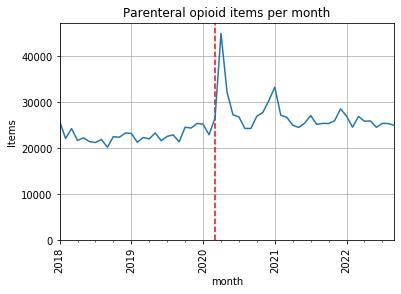

In [6]:
plot(
    df=OP_DF, 
    column_to_plot='ParenteralOpioids', 
    chart_title="Parenteral opioid items per month", 
    y_label='Items', 
    y_min=0, 
    y_max=OP_DF['ParenteralOpioids'].max() * 1.05, 
    lockdownline=True
)